In [178]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import os
import time
import datetime as dt
import psutil
from PIL import Image
import matplotlib.pyplot as plt
from random import shuffle
import glob
import pickle
import random
import torchvision
from torch.optim import lr_scheduler
import torch.nn.functional as F

import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [2]:
def no_of_params(model):
    sum_ = 0.
    for key, value in model.state_dict().items():
        sum_ += torch.prod(torch.tensor(value.shape))
        #print(value, "----------", torch.prod(torch.tensor(value.shape)))
    return int(sum_)

In [108]:
class Dataset(torch.utils.data.Dataset):
    def __init__(
        self,
        list_IDs,
    ):
        self.list_IDs  = list_IDs
        self.cache     = {}
        self.input_dir = "D:/Harsh Workspace/Software/GU/instrument_position_detection_using_ML/data/set_3/images/"
        self.label_dir = "D:/Harsh Workspace/Software/GU/instrument_position_detection_using_ML/data/set_3/labels/"
        
    def __len__(self):
        return len(self.list_IDs)
    
    def __getitem__(self, index):
        ID = self.list_IDs[index]
        if ID in self.cache:
            X = self.cache[ID]['X']
            Y = self.cache[ID]['Y']
        else:
            X = torchvision.io.read_image(
                self.input_dir + str(ID) + ".png "
            ).to(torch.float32)
            X = X[1].unsqueeze(0)/256.
            
            with open(self.label_dir + str(ID), 'rb') as fb:
                Y  = pickle.load(fb)
                
            #Y = [ (i + 3.)/6. for i in Y[0] ] + [i/3.14 for i in Y[1]]
            #Y = [ i/3. for i in Y[0] ] + [i/3.14 for i in Y[1]]
            
            Y = Y[0][1]#/3.1415926
            Y = torch.tensor( Y, dtype=torch.float32 ).unsqueeze(0)
            
            if psutil.virtual_memory().percent < 50:
                data = {
                    'X' : X,
                    'Y' : Y
                }
                self.cache[ID] = data
        return X,Y

In [109]:
all_ids = [str(i) for i in  list(np.arange(0,1000,1))]
train_ids = all_ids[:800]
val_ids   = all_ids[800:]
params = {
    'batch_size'  : 32,
    'shuffle'     : True,
    #'num_workers' : 2
}
training_set         = Dataset(train_ids)
training_generator   = torch.utils.data.DataLoader(
                            training_set,
                            **params,
                            pin_memory=True
                        )
validation_set       = Dataset(val_ids)
validation_generator = torch.utils.data.DataLoader(
                            validation_set,
                            **params,
                            pin_memory=True
                        )

In [110]:
for batch in training_generator:
    break
batch[0].shape

torch.Size([32, 1, 32, 32])

tensor([-0.7864])

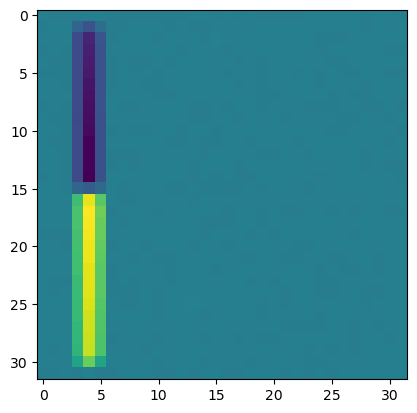

In [111]:
i = 3
plt.imshow(batch[0][i][0])
batch[1][i]

In [163]:
def train_one_epoch(
    model,
    optimizer
):
    running_loss = 0.
    loss_fn = nn.MSELoss()
    
    model.train(True)
    
    for i,batch in enumerate(training_generator):
        X = batch[0]
        Y = batch[1]
        output = model(batch[0])
        loss = loss_fn(Y, output)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        del X,Y,output
    
    return running_loss/(i+1)

def validate_one_epoch(
    model,
    optimizer
):
    running_loss = 0.
    loss_fn = nn.MSELoss()
    model.train(False)
    model.eval()
    
    for i,batch in enumerate(validation_generator):
        X = batch[0]
        Y = batch[1]
        output = model(batch[0])
        loss = loss_fn(Y, output)
        #optimizer.step()
        
        running_loss += loss.item()
        del X,Y,output
    
    return running_loss/(i+1)

In [164]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=5, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(3)
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=5, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(12)
        self.pool = nn.MaxPool2d(2,2)
        self.conv4 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=5, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(24)
        self.conv5 = nn.Conv2d(in_channels=24, out_channels=24, kernel_size=5, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(24)
        self.fc1 = nn.Linear(24*10*10, 1)

    def forward(self, input):
        output = torch.tanh(self.bn1(self.conv1(input)))      
        output = torch.tanh(self.bn2(self.conv2(output)))     
        output = self.pool(output)                        
        output = torch.tanh(self.bn4(self.conv4(output)))     
        output = torch.tanh(self.bn5(self.conv5(output))) 
        output = output.view(-1, 24*10*10)
        output = self.fc1(output)
        output = torch.tanh(output)

        return output

In [165]:
del model

In [166]:
model = Network()
no_of_params(model)

25295

In [167]:
lr = 1e-6
wd = 1e-4
epochs = 1000
optimizer = torch.optim.Adam(
        model.parameters(),
        lr           = lr,
        weight_decay = wd
    )

gamma = 0.95
scheduler_step_size = 1
scheduler = lr_scheduler.StepLR(
    optimizer, 
    step_size = scheduler_step_size, 
    gamma     = gamma)

# scheduler = lr_scheduler.ExponentialLR(
#     optimizer, 
#     #step_size = scheduler_step_size, 
#     gamma     = gamma)

In [168]:
train_losses = []
val_losses   = []
lrs          = []
for epoch in range(epochs):
    train_loss = train_one_epoch(model,optimizer)
    val_loss   = validate_one_epoch(model,optimizer)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    lrs.append(scheduler.optimizer.param_groups[0]['lr'])
    scheduler.step()
    print("EPOCH: ",epoch + 1, " Train loss: ", round(train_loss,4), " Val loss: ",round(val_loss,4), " LR: ",round(scheduler.optimizer.param_groups[0]['lr'],10))

EPOCH:  1  Train loss:  0.3761  Val loss:  0.3092  LR:  9.5e-07
EPOCH:  2  Train loss:  0.3406  Val loss:  0.3532  LR:  9.025e-07
EPOCH:  3  Train loss:  0.3048  Val loss:  0.3078  LR:  8.574e-07
EPOCH:  4  Train loss:  0.2716  Val loss:  0.2522  LR:  8.145e-07
EPOCH:  5  Train loss:  0.2406  Val loss:  0.2263  LR:  7.738e-07
EPOCH:  6  Train loss:  0.2142  Val loss:  0.1922  LR:  7.351e-07
EPOCH:  7  Train loss:  0.1912  Val loss:  0.1604  LR:  6.983e-07
EPOCH:  8  Train loss:  0.171  Val loss:  0.1504  LR:  6.634e-07
EPOCH:  9  Train loss:  0.1529  Val loss:  0.1296  LR:  6.302e-07
EPOCH:  10  Train loss:  0.1382  Val loss:  0.1192  LR:  5.987e-07
EPOCH:  11  Train loss:  0.1254  Val loss:  0.1038  LR:  5.688e-07
EPOCH:  12  Train loss:  0.1139  Val loss:  0.0917  LR:  5.404e-07
EPOCH:  13  Train loss:  0.1043  Val loss:  0.0826  LR:  5.133e-07
EPOCH:  14  Train loss:  0.096  Val loss:  0.0781  LR:  4.877e-07
EPOCH:  15  Train loss:  0.0889  Val loss:  0.0686  LR:  4.633e-07
EPOCH:  

EPOCH:  126  Train loss:  0.0269  Val loss:  0.0195  LR:  1.6e-09
EPOCH:  127  Train loss:  0.0269  Val loss:  0.0201  LR:  1.5e-09
EPOCH:  128  Train loss:  0.0271  Val loss:  0.0199  LR:  1.4e-09
EPOCH:  129  Train loss:  0.027  Val loss:  0.0209  LR:  1.3e-09
EPOCH:  130  Train loss:  0.0267  Val loss:  0.0201  LR:  1.3e-09
EPOCH:  131  Train loss:  0.0269  Val loss:  0.0195  LR:  1.2e-09
EPOCH:  132  Train loss:  0.0268  Val loss:  0.0211  LR:  1.1e-09
EPOCH:  133  Train loss:  0.0268  Val loss:  0.0198  LR:  1.1e-09
EPOCH:  134  Train loss:  0.0267  Val loss:  0.0191  LR:  1e-09
EPOCH:  135  Train loss:  0.0267  Val loss:  0.0214  LR:  1e-09
EPOCH:  136  Train loss:  0.0267  Val loss:  0.0218  LR:  9e-10
EPOCH:  137  Train loss:  0.0267  Val loss:  0.0199  LR:  9e-10
EPOCH:  138  Train loss:  0.0267  Val loss:  0.0207  LR:  8e-10
EPOCH:  139  Train loss:  0.0268  Val loss:  0.0198  LR:  8e-10
EPOCH:  140  Train loss:  0.0266  Val loss:  0.0227  LR:  8e-10
EPOCH:  141  Train loss: 

EPOCH:  257  Train loss:  0.0268  Val loss:  0.0229  LR:  0.0
EPOCH:  258  Train loss:  0.0269  Val loss:  0.0201  LR:  0.0
EPOCH:  259  Train loss:  0.0268  Val loss:  0.0203  LR:  0.0
EPOCH:  260  Train loss:  0.0268  Val loss:  0.0206  LR:  0.0
EPOCH:  261  Train loss:  0.0267  Val loss:  0.0196  LR:  0.0
EPOCH:  262  Train loss:  0.0268  Val loss:  0.0222  LR:  0.0
EPOCH:  263  Train loss:  0.0268  Val loss:  0.0198  LR:  0.0
EPOCH:  264  Train loss:  0.0268  Val loss:  0.0209  LR:  0.0
EPOCH:  265  Train loss:  0.0269  Val loss:  0.0213  LR:  0.0
EPOCH:  266  Train loss:  0.0267  Val loss:  0.0198  LR:  0.0
EPOCH:  267  Train loss:  0.0267  Val loss:  0.0206  LR:  0.0
EPOCH:  268  Train loss:  0.0266  Val loss:  0.0199  LR:  0.0
EPOCH:  269  Train loss:  0.0267  Val loss:  0.0205  LR:  0.0
EPOCH:  270  Train loss:  0.0267  Val loss:  0.0211  LR:  0.0
EPOCH:  271  Train loss:  0.0269  Val loss:  0.019  LR:  0.0
EPOCH:  272  Train loss:  0.0268  Val loss:  0.0195  LR:  0.0
EPOCH:  2

EPOCH:  390  Train loss:  0.0268  Val loss:  0.021  LR:  0.0
EPOCH:  391  Train loss:  0.027  Val loss:  0.0201  LR:  0.0
EPOCH:  392  Train loss:  0.0267  Val loss:  0.0209  LR:  0.0
EPOCH:  393  Train loss:  0.0265  Val loss:  0.0196  LR:  0.0
EPOCH:  394  Train loss:  0.0266  Val loss:  0.0197  LR:  0.0
EPOCH:  395  Train loss:  0.0268  Val loss:  0.0204  LR:  0.0
EPOCH:  396  Train loss:  0.0267  Val loss:  0.0193  LR:  0.0
EPOCH:  397  Train loss:  0.0269  Val loss:  0.0201  LR:  0.0
EPOCH:  398  Train loss:  0.027  Val loss:  0.0205  LR:  0.0
EPOCH:  399  Train loss:  0.0268  Val loss:  0.02  LR:  0.0
EPOCH:  400  Train loss:  0.0268  Val loss:  0.0201  LR:  0.0
EPOCH:  401  Train loss:  0.0271  Val loss:  0.0201  LR:  0.0
EPOCH:  402  Train loss:  0.0267  Val loss:  0.0205  LR:  0.0
EPOCH:  403  Train loss:  0.0267  Val loss:  0.0201  LR:  0.0
EPOCH:  404  Train loss:  0.027  Val loss:  0.0216  LR:  0.0
EPOCH:  405  Train loss:  0.0268  Val loss:  0.0201  LR:  0.0
EPOCH:  406  T

EPOCH:  523  Train loss:  0.0269  Val loss:  0.0191  LR:  0.0
EPOCH:  524  Train loss:  0.0266  Val loss:  0.0211  LR:  0.0
EPOCH:  525  Train loss:  0.0269  Val loss:  0.0196  LR:  0.0
EPOCH:  526  Train loss:  0.0269  Val loss:  0.0235  LR:  0.0
EPOCH:  527  Train loss:  0.027  Val loss:  0.0194  LR:  0.0
EPOCH:  528  Train loss:  0.0268  Val loss:  0.0207  LR:  0.0
EPOCH:  529  Train loss:  0.0271  Val loss:  0.0232  LR:  0.0
EPOCH:  530  Train loss:  0.0269  Val loss:  0.0236  LR:  0.0
EPOCH:  531  Train loss:  0.0267  Val loss:  0.0213  LR:  0.0
EPOCH:  532  Train loss:  0.0267  Val loss:  0.0214  LR:  0.0
EPOCH:  533  Train loss:  0.0269  Val loss:  0.0207  LR:  0.0
EPOCH:  534  Train loss:  0.0267  Val loss:  0.0198  LR:  0.0
EPOCH:  535  Train loss:  0.0268  Val loss:  0.0192  LR:  0.0
EPOCH:  536  Train loss:  0.0267  Val loss:  0.0229  LR:  0.0
EPOCH:  537  Train loss:  0.0268  Val loss:  0.0196  LR:  0.0
EPOCH:  538  Train loss:  0.0269  Val loss:  0.0203  LR:  0.0
EPOCH:  5

EPOCH:  656  Train loss:  0.0267  Val loss:  0.0199  LR:  0.0
EPOCH:  657  Train loss:  0.0269  Val loss:  0.0213  LR:  0.0
EPOCH:  658  Train loss:  0.0266  Val loss:  0.0202  LR:  0.0
EPOCH:  659  Train loss:  0.0269  Val loss:  0.0203  LR:  0.0
EPOCH:  660  Train loss:  0.0268  Val loss:  0.0197  LR:  0.0
EPOCH:  661  Train loss:  0.027  Val loss:  0.0202  LR:  0.0
EPOCH:  662  Train loss:  0.0269  Val loss:  0.0248  LR:  0.0
EPOCH:  663  Train loss:  0.0268  Val loss:  0.0199  LR:  0.0
EPOCH:  664  Train loss:  0.0265  Val loss:  0.0196  LR:  0.0
EPOCH:  665  Train loss:  0.0269  Val loss:  0.0242  LR:  0.0
EPOCH:  666  Train loss:  0.0269  Val loss:  0.0197  LR:  0.0
EPOCH:  667  Train loss:  0.0268  Val loss:  0.0199  LR:  0.0
EPOCH:  668  Train loss:  0.0269  Val loss:  0.0218  LR:  0.0
EPOCH:  669  Train loss:  0.0265  Val loss:  0.0194  LR:  0.0
EPOCH:  670  Train loss:  0.0267  Val loss:  0.0203  LR:  0.0
EPOCH:  671  Train loss:  0.0266  Val loss:  0.0202  LR:  0.0
EPOCH:  6

EPOCH:  789  Train loss:  0.0269  Val loss:  0.0194  LR:  0.0
EPOCH:  790  Train loss:  0.0267  Val loss:  0.0222  LR:  0.0
EPOCH:  791  Train loss:  0.027  Val loss:  0.0197  LR:  0.0
EPOCH:  792  Train loss:  0.0267  Val loss:  0.0208  LR:  0.0
EPOCH:  793  Train loss:  0.0268  Val loss:  0.0206  LR:  0.0
EPOCH:  794  Train loss:  0.027  Val loss:  0.0206  LR:  0.0
EPOCH:  795  Train loss:  0.0268  Val loss:  0.0215  LR:  0.0
EPOCH:  796  Train loss:  0.0267  Val loss:  0.0206  LR:  0.0
EPOCH:  797  Train loss:  0.0268  Val loss:  0.0208  LR:  0.0
EPOCH:  798  Train loss:  0.0269  Val loss:  0.0196  LR:  0.0
EPOCH:  799  Train loss:  0.0267  Val loss:  0.0213  LR:  0.0
EPOCH:  800  Train loss:  0.0267  Val loss:  0.02  LR:  0.0
EPOCH:  801  Train loss:  0.0269  Val loss:  0.0205  LR:  0.0
EPOCH:  802  Train loss:  0.0268  Val loss:  0.0192  LR:  0.0
EPOCH:  803  Train loss:  0.0269  Val loss:  0.0199  LR:  0.0
EPOCH:  804  Train loss:  0.0269  Val loss:  0.02  LR:  0.0
EPOCH:  805  T

EPOCH:  922  Train loss:  0.0269  Val loss:  0.0205  LR:  0.0
EPOCH:  923  Train loss:  0.0267  Val loss:  0.0209  LR:  0.0
EPOCH:  924  Train loss:  0.0269  Val loss:  0.0228  LR:  0.0
EPOCH:  925  Train loss:  0.0266  Val loss:  0.0196  LR:  0.0
EPOCH:  926  Train loss:  0.0268  Val loss:  0.0196  LR:  0.0
EPOCH:  927  Train loss:  0.027  Val loss:  0.0189  LR:  0.0
EPOCH:  928  Train loss:  0.0266  Val loss:  0.0206  LR:  0.0
EPOCH:  929  Train loss:  0.0269  Val loss:  0.0197  LR:  0.0
EPOCH:  930  Train loss:  0.0267  Val loss:  0.0202  LR:  0.0
EPOCH:  931  Train loss:  0.0267  Val loss:  0.0215  LR:  0.0
EPOCH:  932  Train loss:  0.0268  Val loss:  0.0197  LR:  0.0
EPOCH:  933  Train loss:  0.0268  Val loss:  0.0197  LR:  0.0
EPOCH:  934  Train loss:  0.0266  Val loss:  0.0199  LR:  0.0
EPOCH:  935  Train loss:  0.0267  Val loss:  0.0211  LR:  0.0
EPOCH:  936  Train loss:  0.0272  Val loss:  0.0215  LR:  0.0
EPOCH:  937  Train loss:  0.0265  Val loss:  0.0225  LR:  0.0
EPOCH:  9

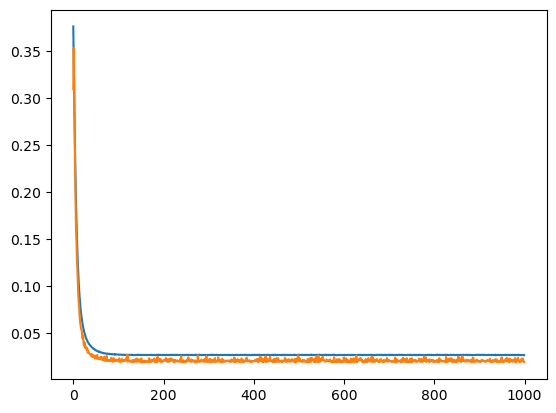

In [169]:
plt.plot(train_losses)
plt.plot(val_losses)

In [219]:
for batch in validation_generator:
    break
output = model(batch[0])
output

tensor([[ 0.6639],
        [ 0.6908],
        [ 0.4985],
        [-0.4114],
        [-0.3263],
        [ 0.7900],
        [-0.2474],
        [ 0.6347],
        [-0.7308],
        [-0.1094],
        [-0.7165],
        [ 0.4495],
        [ 0.6640],
        [ 0.6850],
        [ 0.3228],
        [ 0.8269],
        [ 0.3189],
        [ 0.4436],
        [ 0.6692],
        [ 0.8375],
        [-0.7158],
        [ 0.6746],
        [ 0.6414],
        [ 0.6807],
        [ 0.4475],
        [-0.3687],
        [-0.5161],
        [-0.7249],
        [-0.0147],
        [-0.4843],
        [ 0.0833],
        [ 0.7384]], grad_fn=<TanhBackward0>)

In [220]:
batch[1]

tensor([[ 0.6790],
        [ 0.5308],
        [ 0.4436],
        [-0.4404],
        [-0.1946],
        [ 0.8391],
        [-0.2744],
        [ 0.5445],
        [-0.6360],
        [-0.0746],
        [-0.6222],
        [ 0.2352],
        [ 0.9283],
        [ 0.5622],
        [ 0.1395],
        [ 0.8120],
        [ 0.2716],
        [ 0.2375],
        [ 0.6698],
        [ 0.7989],
        [-0.6191],
        [ 0.6227],
        [ 0.6323],
        [ 0.6199],
        [ 0.2382],
        [-0.4543],
        [-0.4958],
        [-0.7534],
        [-0.0387],
        [-0.4911],
        [ 0.0153],
        [ 0.8485]])

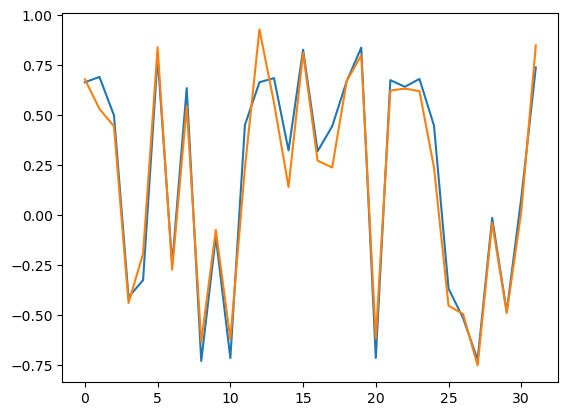

In [222]:
plt.plot(output.detach().numpy())
plt.plot(batch[1].detach().numpy())

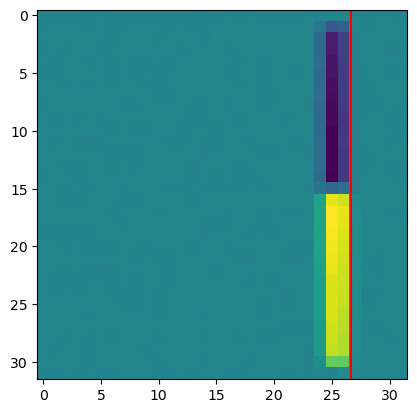

In [229]:
plt.imshow(batch[0][0][0])
plt.axvline( x = ( output[0].detach().numpy()  + 1.)*16, c='r')

(0.0, 20.0)

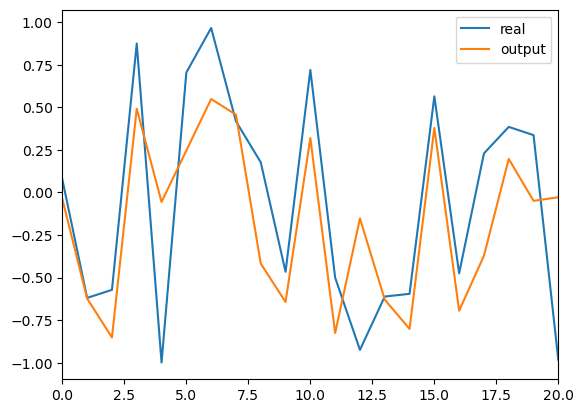

In [251]:
plt.plot(real,label="real")
plt.plot(outputs,label="output")
plt.legend()
plt.xlim(0,20)

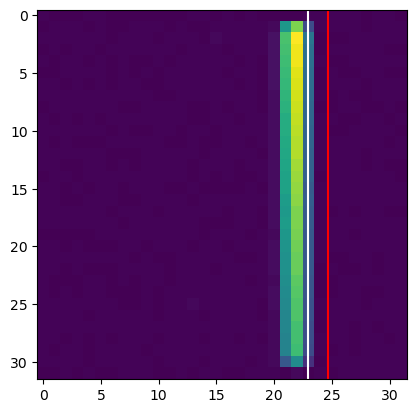

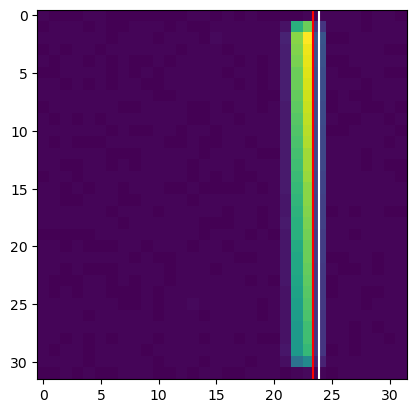

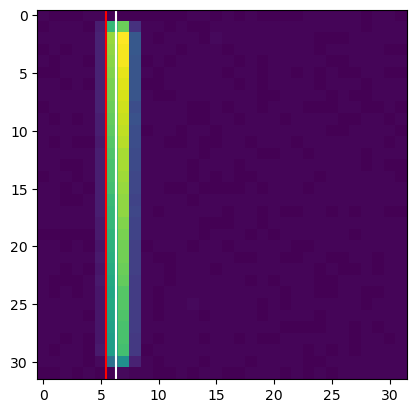

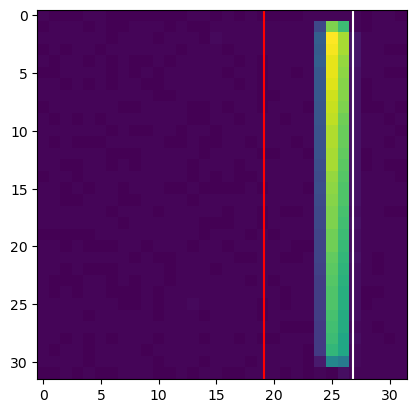

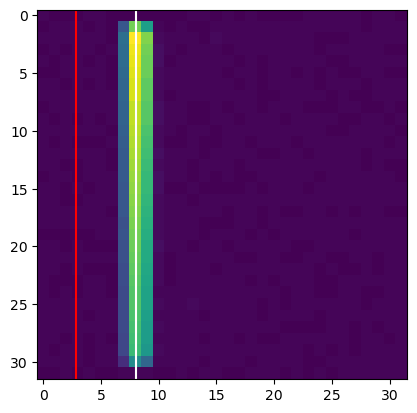

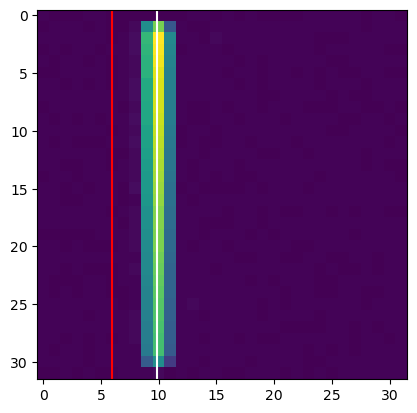

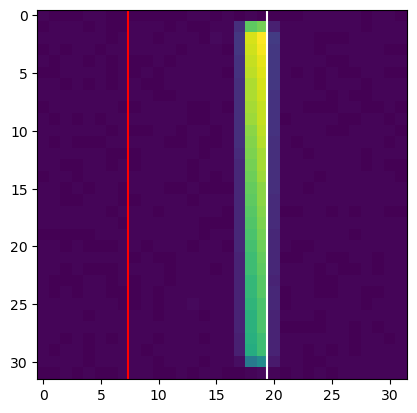

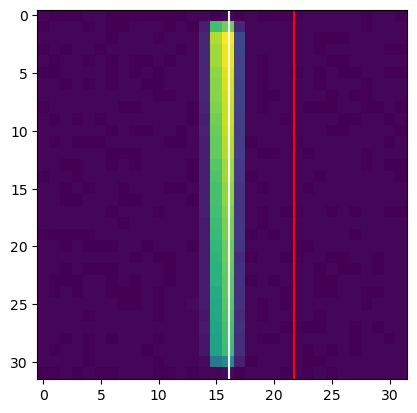

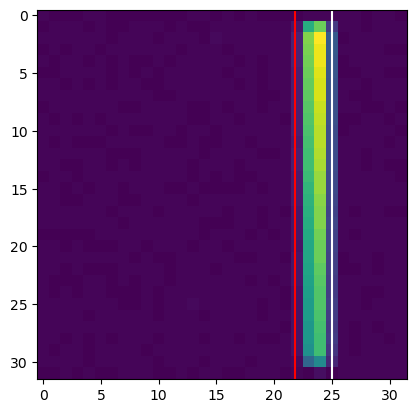

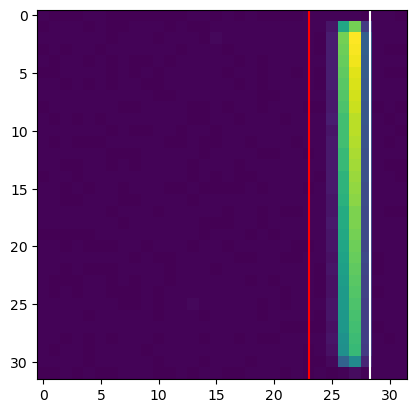

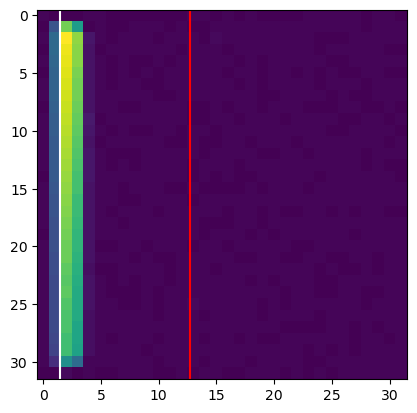

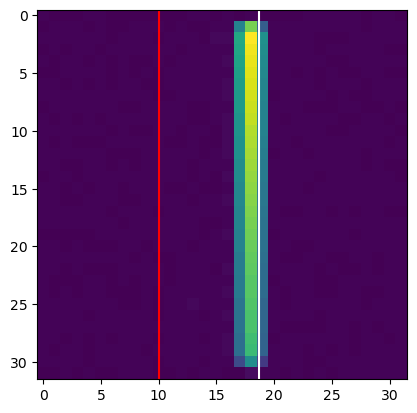

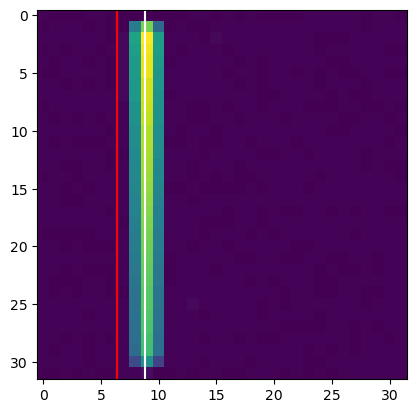

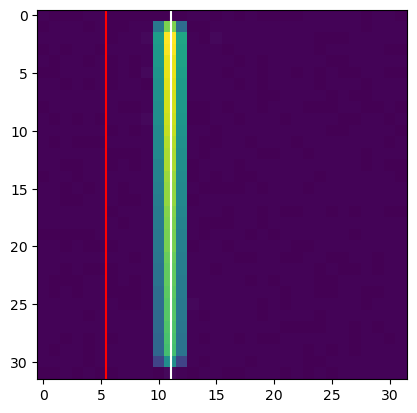

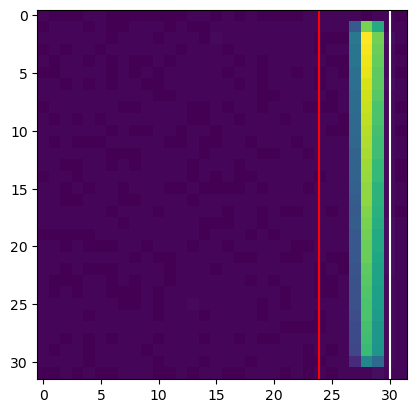

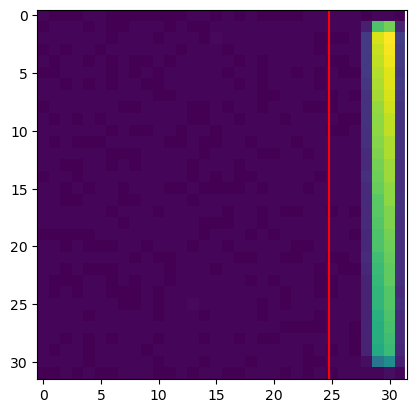

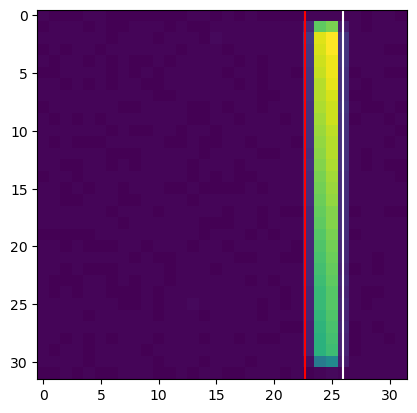

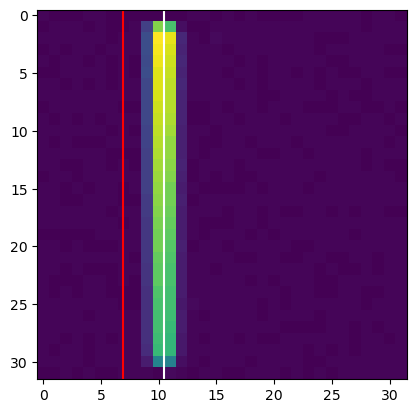

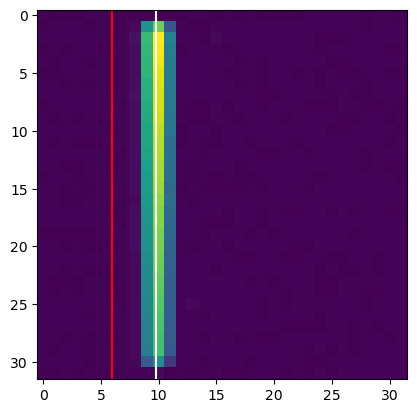

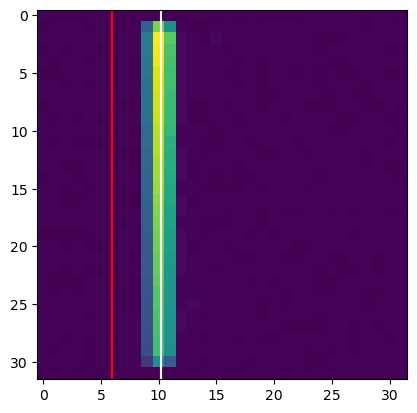

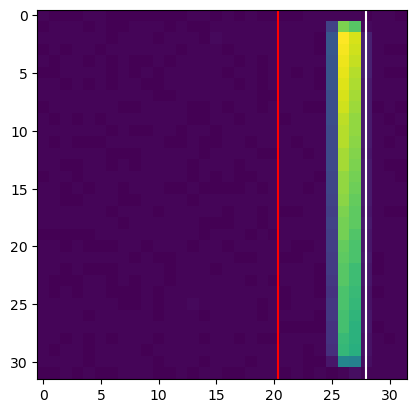

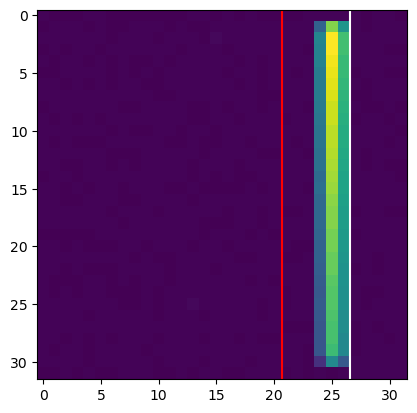

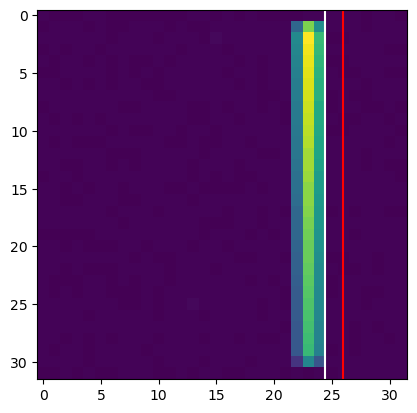

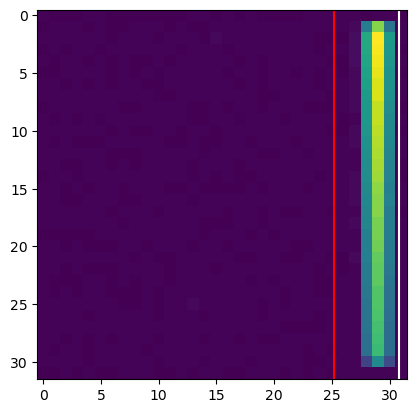

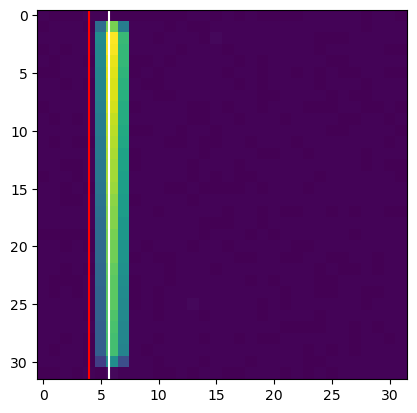

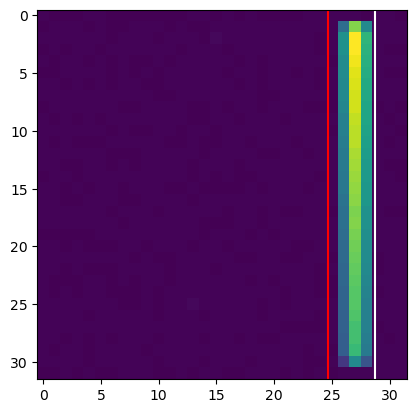

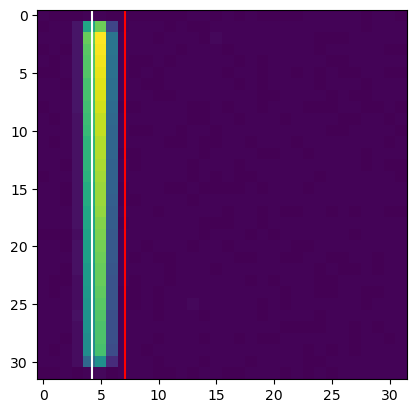

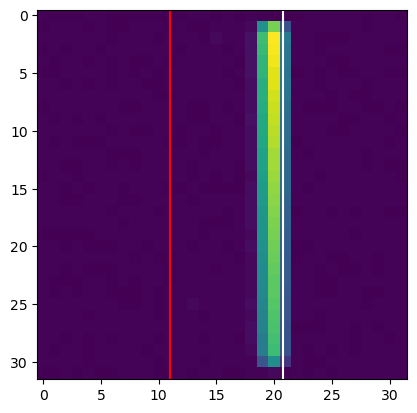

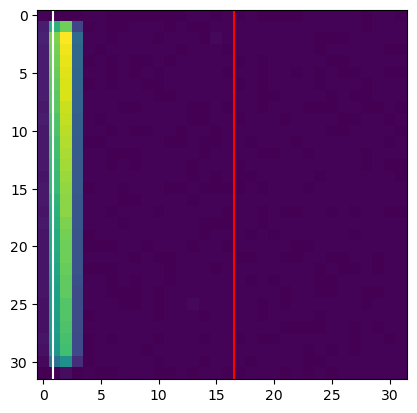

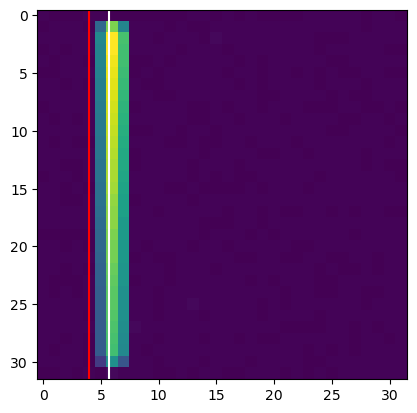

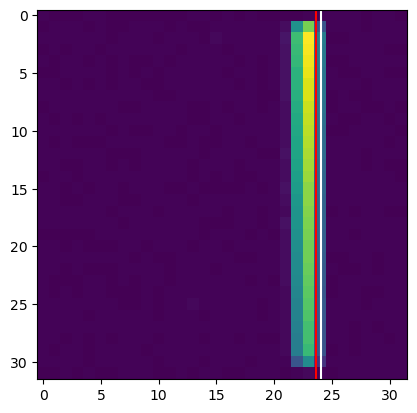

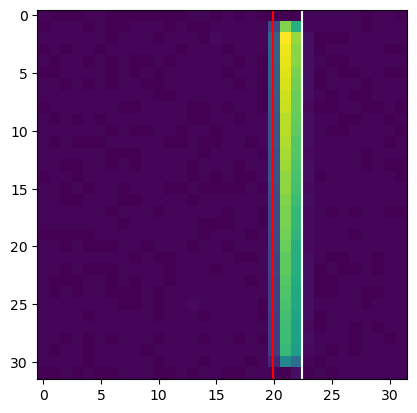

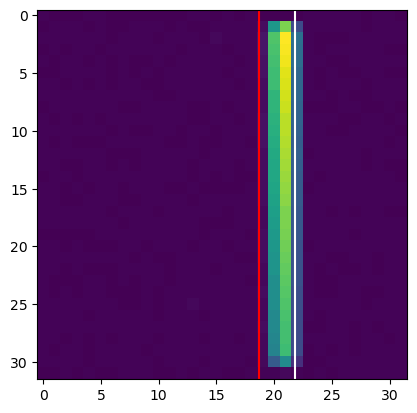

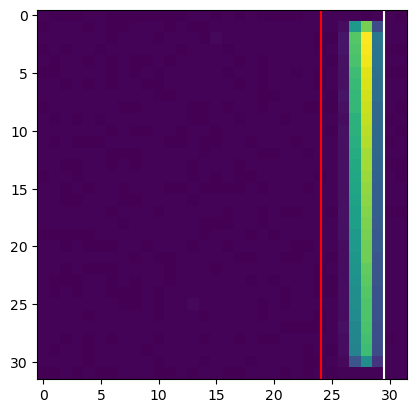

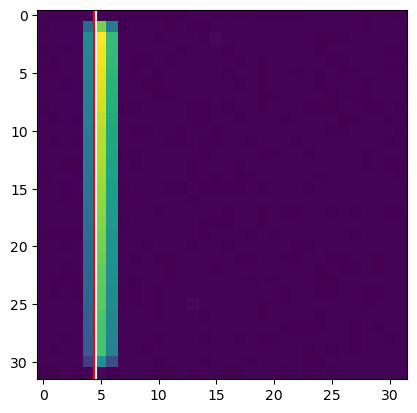

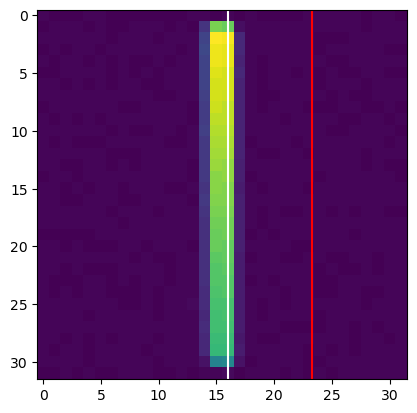

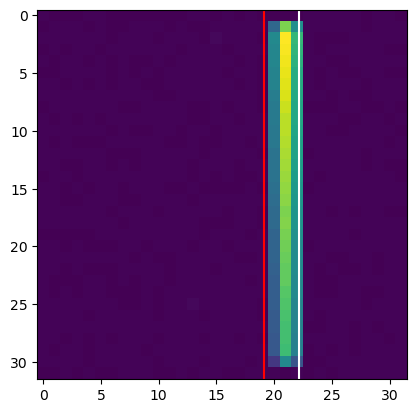

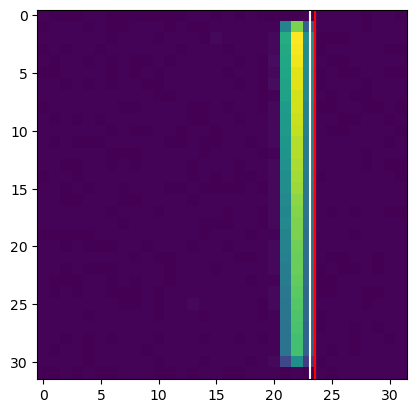

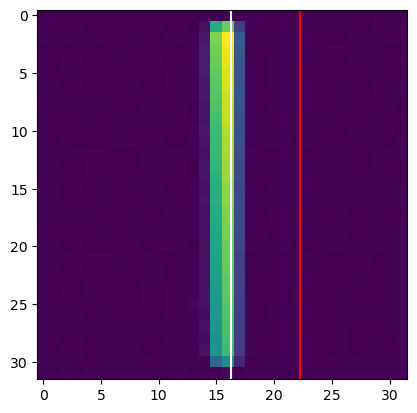

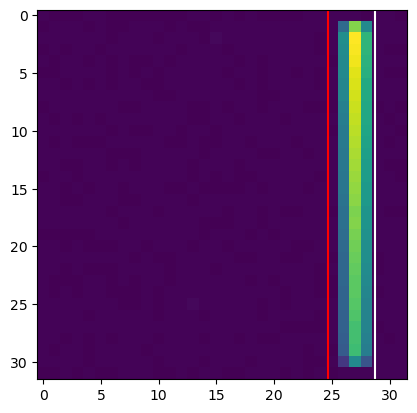

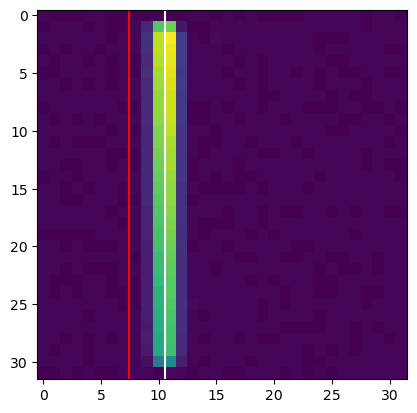

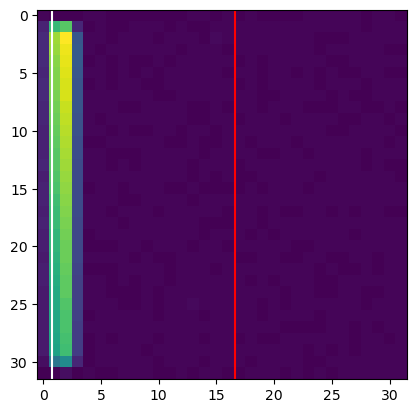

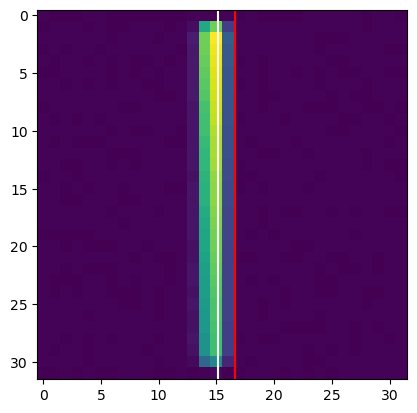

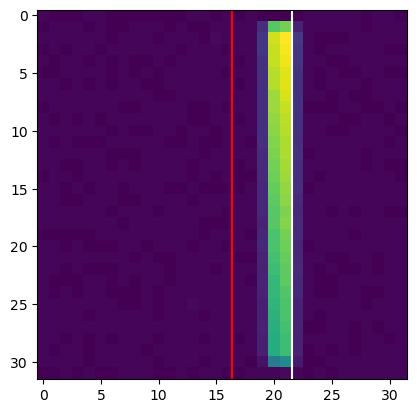

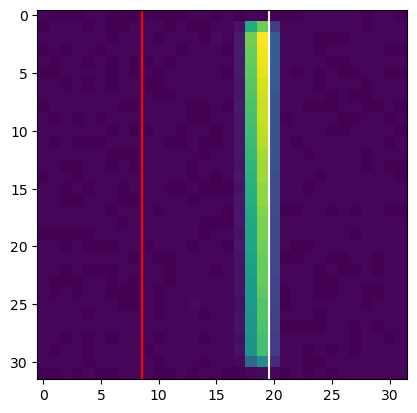

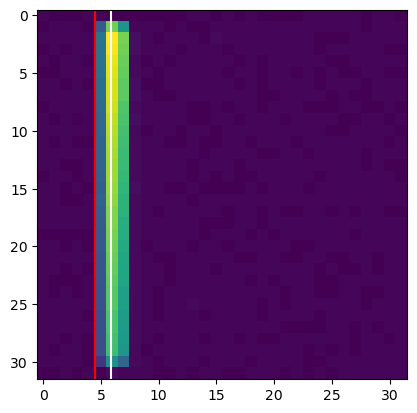

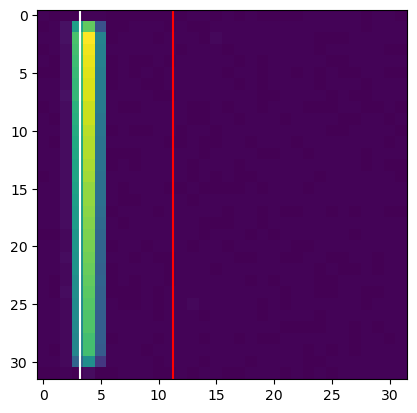

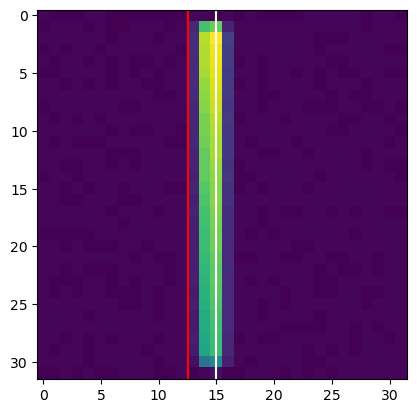

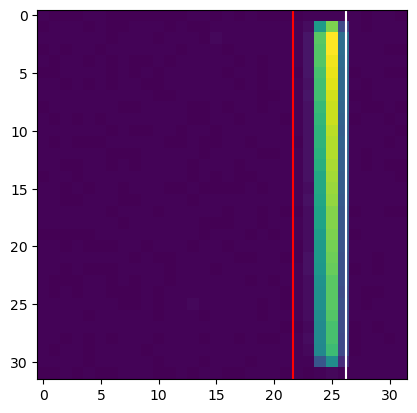

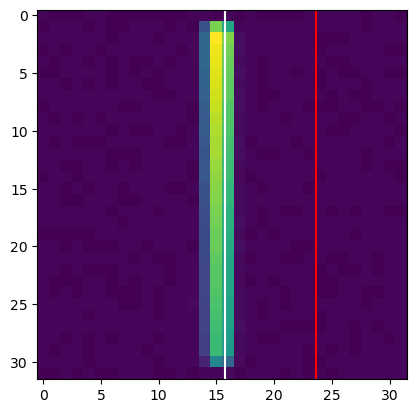

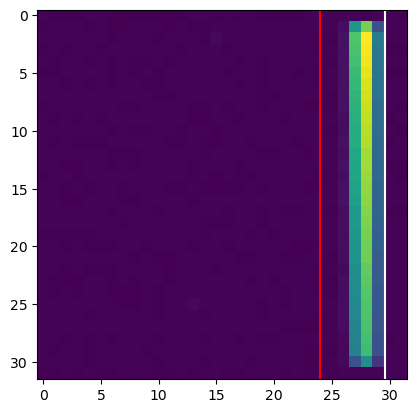

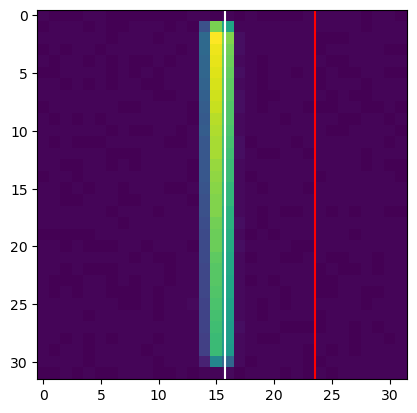

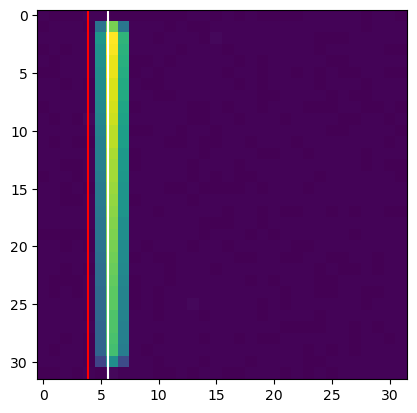

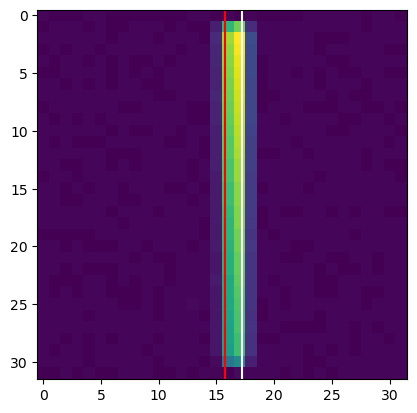

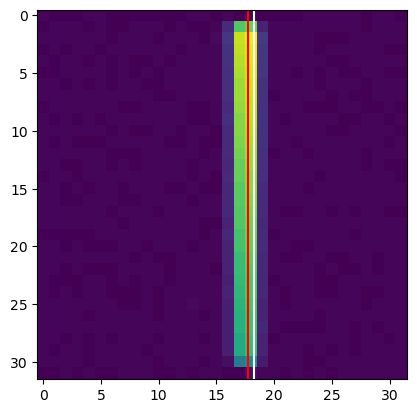

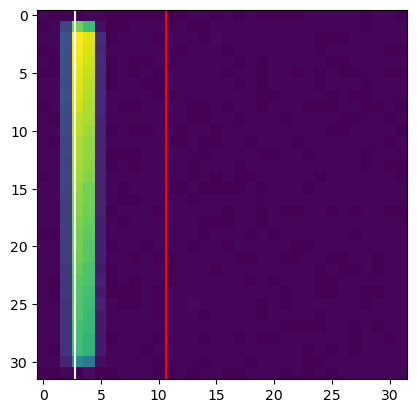

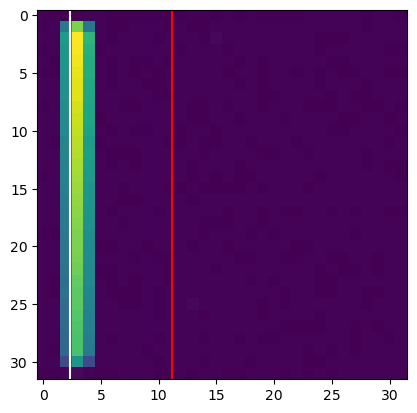

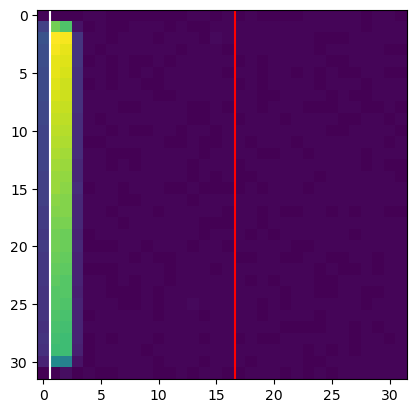

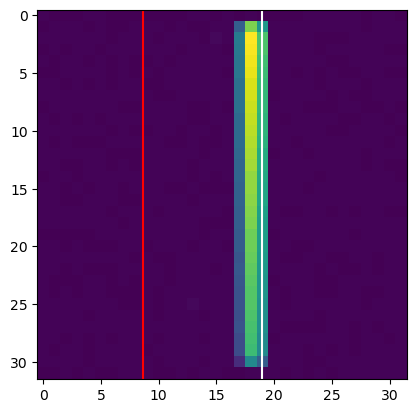

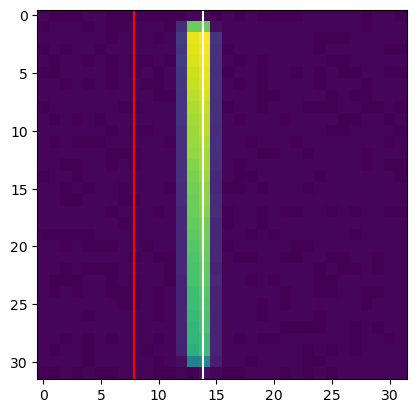

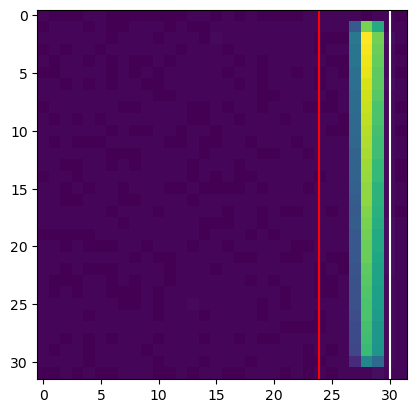

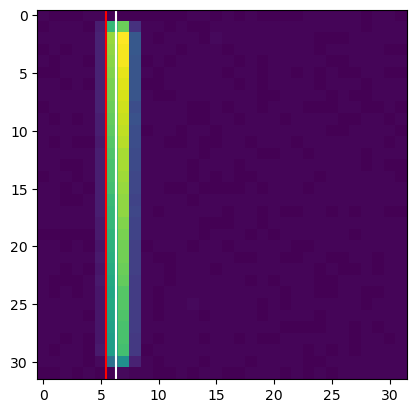

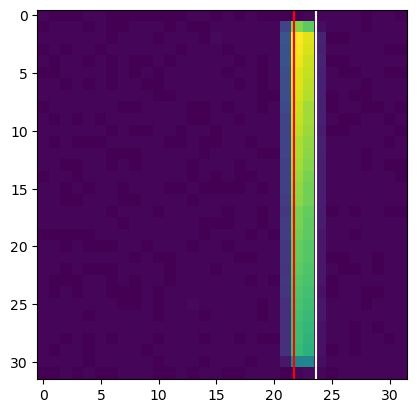

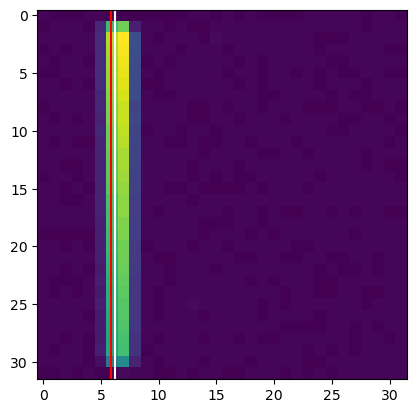

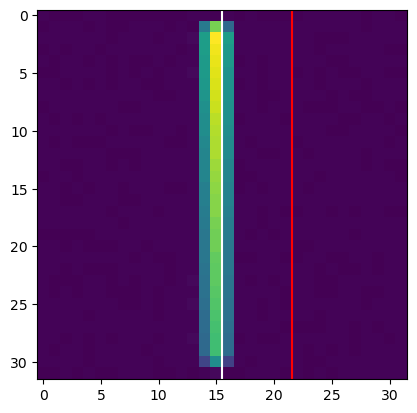

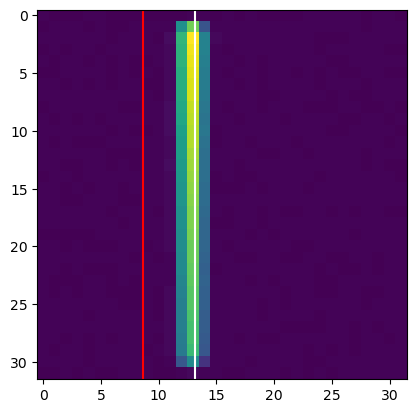

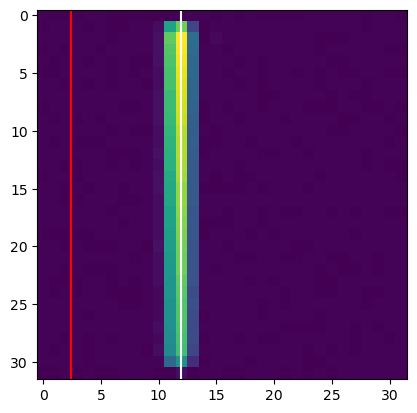

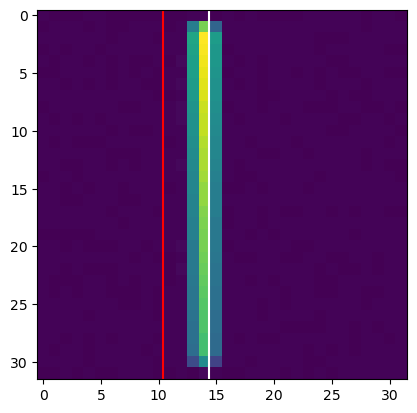

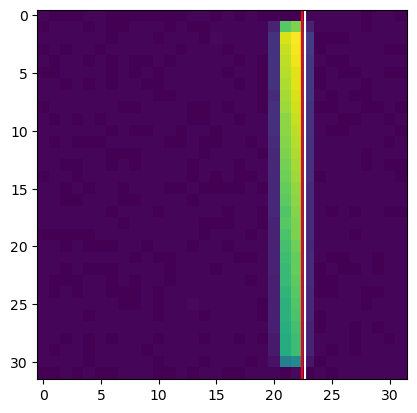

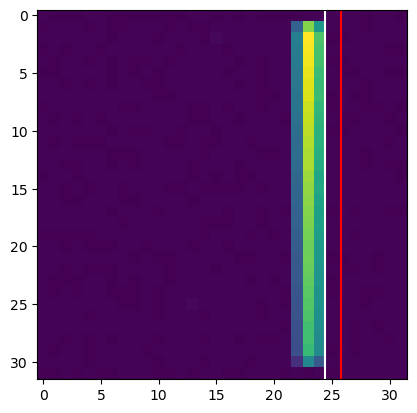

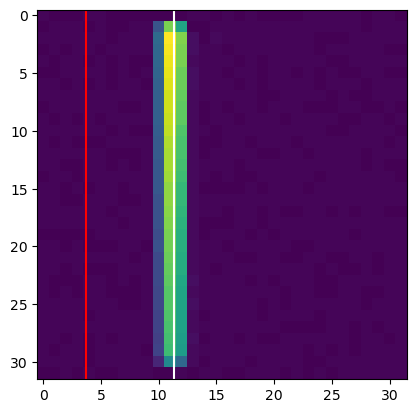

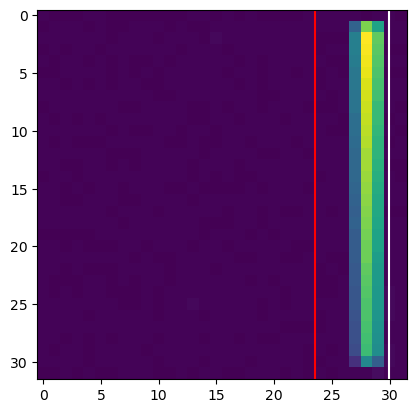

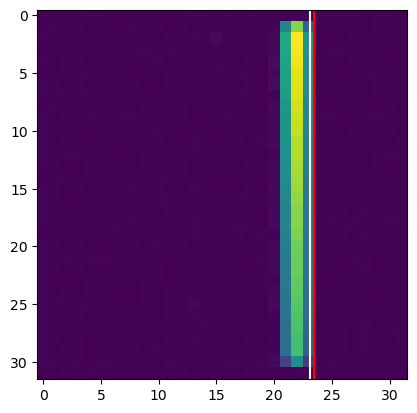

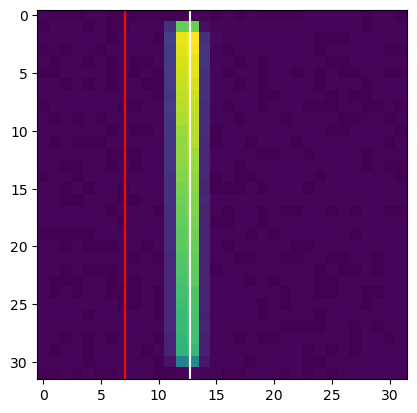

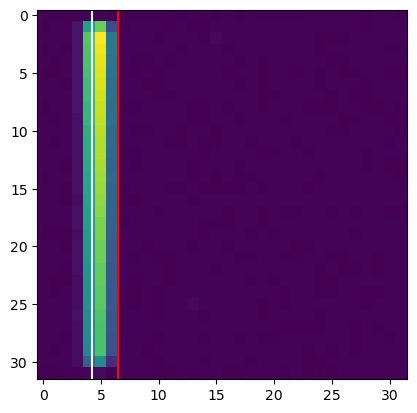

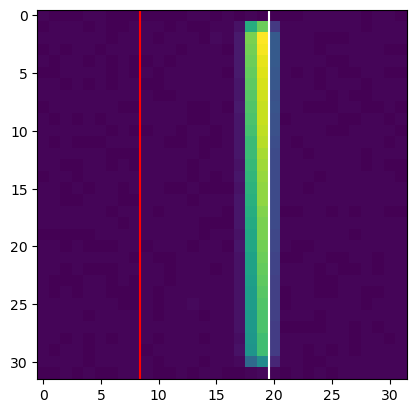

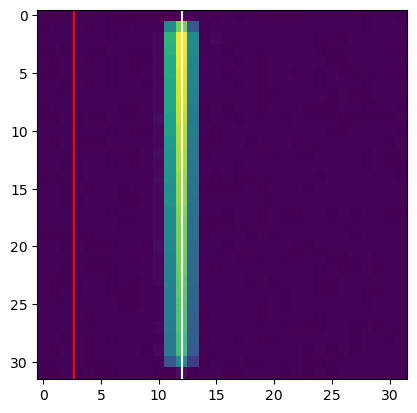

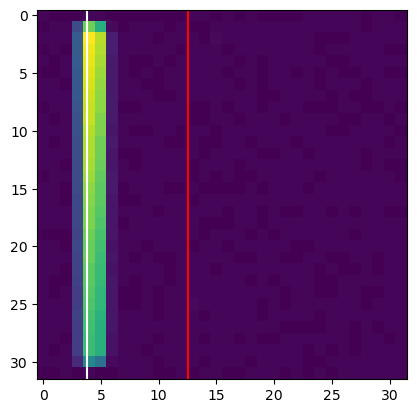

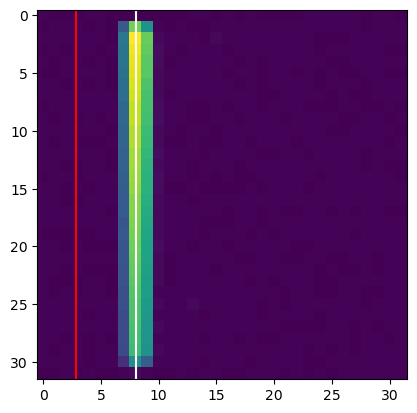

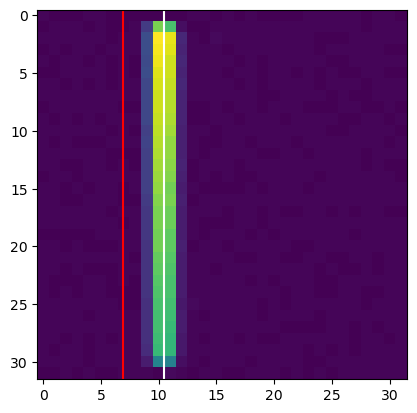

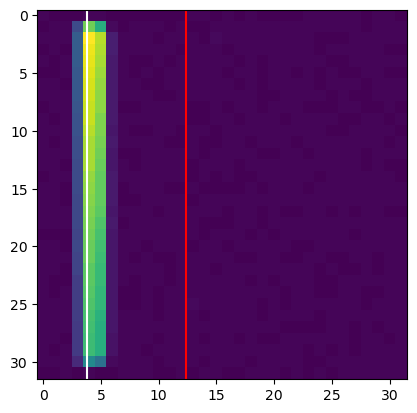

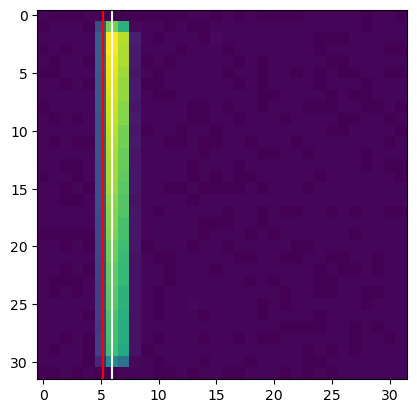

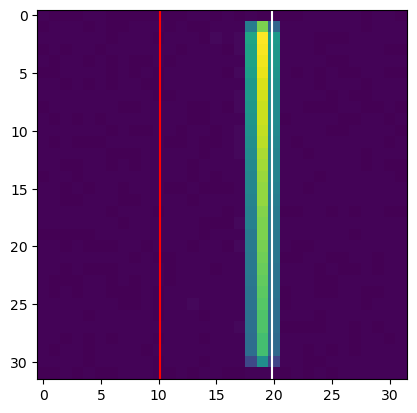

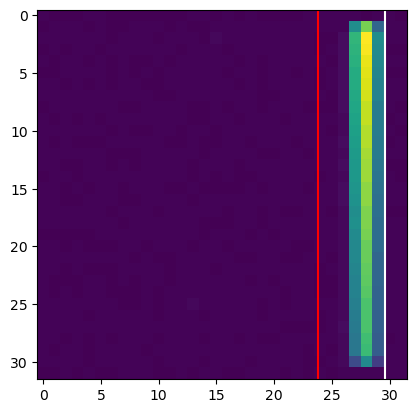

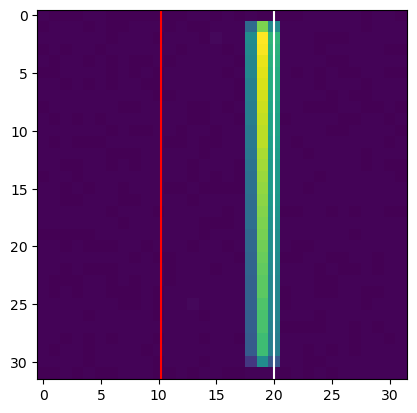

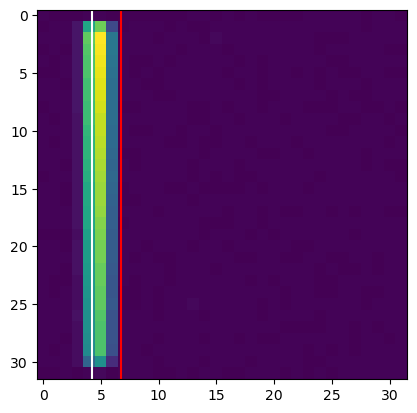

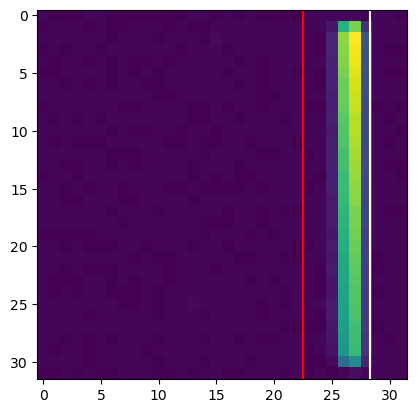

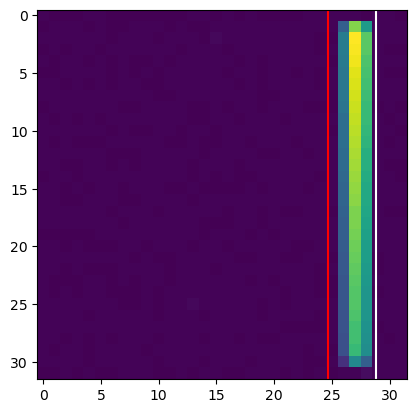

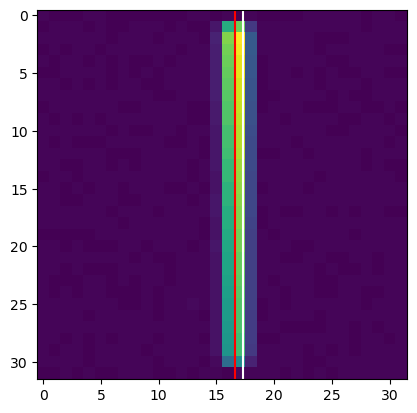

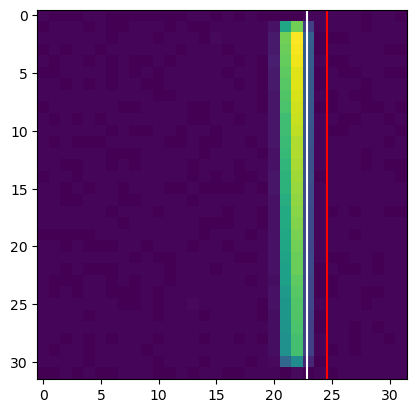

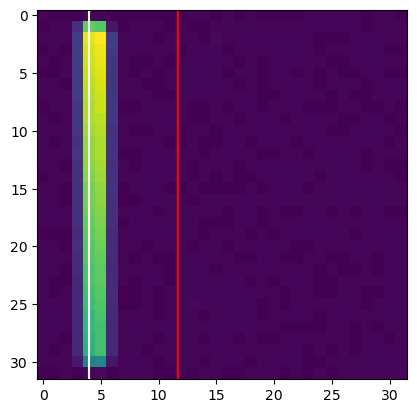

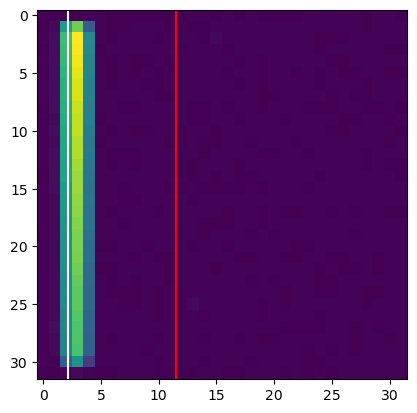

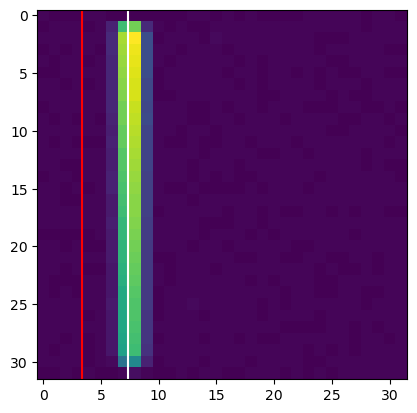

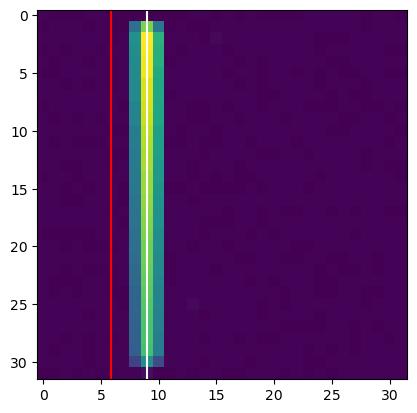

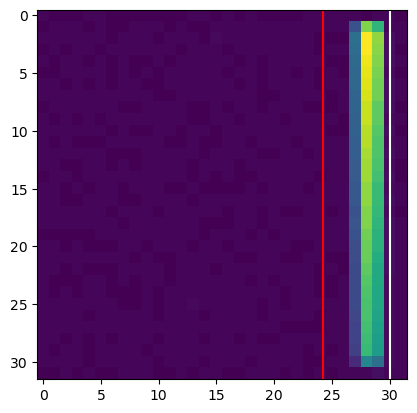

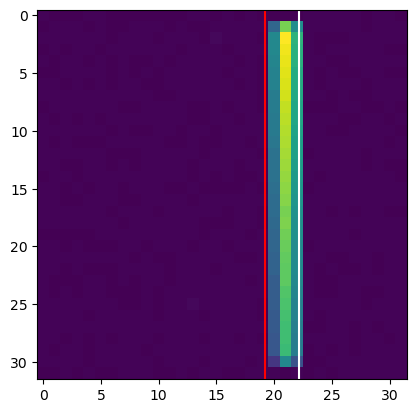

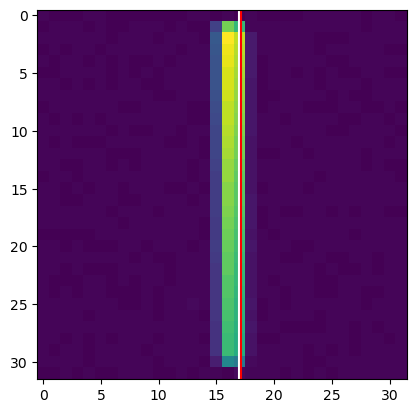

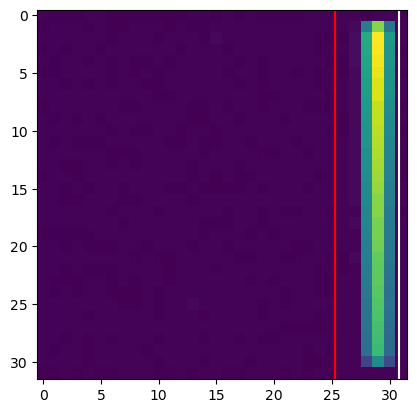

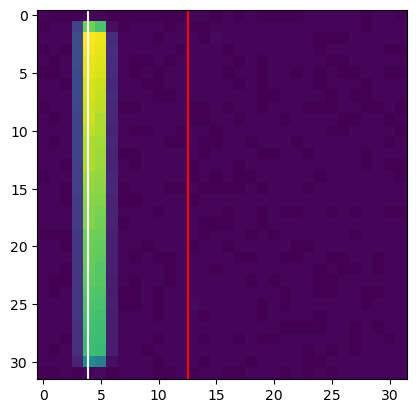

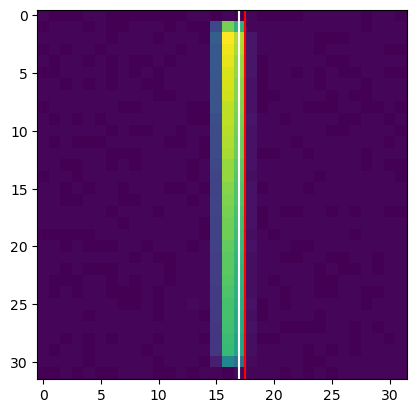

In [252]:
test_IDs = [ random.randint(0,999) for i in range(100) ]

real = []
outputs = []
for ID in test_IDs:
    input_dir = "D:/Harsh Workspace/Software/GU/instrument_position_detection_using_ML/data/set_3/images/"
    label_dir = "D:/Harsh Workspace/Software/GU/instrument_position_detection_using_ML/data/set_3/labels/"
    
    X = torchvision.io.read_image(
                input_dir + str(ID) + ".png "
            ).to(torch.float32)
    plt.imshow(X[0])
    X = X/256.
    
    with open(label_dir + str(ID), 'rb') as fb:
        Y  = pickle.load(fb)
        Y = Y[0][1]#/3.1415926
        
    output = float(model(X[0].unsqueeze(0).unsqueeze(0)))
    
    real.append(Y)
    outputs.append(output)
    
    plt.axvline( x = (Y + 1)*16, c='w' )
    plt.axvline( x = (output + 1.)*16, c='r')
    plt.show()
    
        

# Training using vision transformer

In [257]:
from vit_pytorch import ViT
model = ViT(
        image_size  = 32,#256,
        channels    = 1,#1,
        patch_size  = 4,
        num_classes = 1,
        dim         = 32,
        depth       = 2,
        heads       = 4,
        mlp_dim     = 64,
        dropout     = 0.1,
        emb_dropout = 0.1,
    )
no_of_params(model)

77089

In [267]:
lr = 1e-6
wd = 1e-4
epochs = 10
optimizer = torch.optim.Adam(
        model.parameters(),
        lr           = lr,
        weight_decay = wd
    )

gamma = 0.95
scheduler_step_size = 1
scheduler = lr_scheduler.StepLR(
    optimizer, 
    step_size = scheduler_step_size, 
    gamma     = gamma)

# scheduler = lr_scheduler.ExponentialLR(
#     optimizer, 
#     #step_size = scheduler_step_size, 
#     gamma     = gamma)

In [ ]:
train_losses = []
val_losses   = []
lrs          = []
for epoch in range(epochs):
    train_loss = train_one_epoch(model,optimizer)
    val_loss   = validate_one_epoch(model,optimizer)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    lrs.append(scheduler.optimizer.param_groups[0]['lr'])
    scheduler.step()
    print("EPOCH: ",epoch + 1, " Train loss: ", round(train_loss,4), " Val loss: ",round(val_loss,4), " LR: ",round(scheduler.optimizer.param_groups[0]['lr'],10))

EPOCH:  1  Train loss:  0.3132  Val loss:  0.3121  LR:  9.5e-07
EPOCH:  2  Train loss:  0.3164  Val loss:  0.2841  LR:  9.025e-07
EPOCH:  3  Train loss:  0.3175  Val loss:  0.3  LR:  8.574e-07
EPOCH:  4  Train loss:  0.3179  Val loss:  0.2826  LR:  8.145e-07
EPOCH:  5  Train loss:  0.3127  Val loss:  0.2933  LR:  7.738e-07
EPOCH:  6  Train loss:  0.3155  Val loss:  0.2764  LR:  7.351e-07
EPOCH:  7  Train loss:  0.3137  Val loss:  0.3049  LR:  6.983e-07
EPOCH:  8  Train loss:  0.3179  Val loss:  0.2855  LR:  6.634e-07
EPOCH:  9  Train loss:  0.3203  Val loss:  0.2806  LR:  6.302e-07


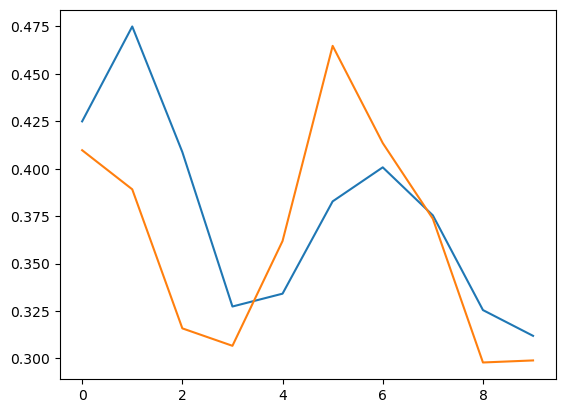

In [262]:
plt.plot(train_losses)
plt.plot(val_losses)

In [265]:
for batch in validation_generator:
    break
output = model(batch[0])
output

tensor([[0.1012],
        [0.1167],
        [0.0702],
        [0.1187],
        [0.1214],
        [0.0724],
        [0.0650],
        [0.0718],
        [0.1295],
        [0.1051],
        [0.0719],
        [0.1212],
        [0.1310],
        [0.0710],
        [0.1180],
        [0.0694],
        [0.1216],
        [0.0658],
        [0.1191],
        [0.0785],
        [0.0653],
        [0.0968],
        [0.0737],
        [0.0727],
        [0.0876],
        [0.1047],
        [0.1293],
        [0.0827],
        [0.1258],
        [0.0679],
        [0.0674],
        [0.0574]], grad_fn=<AddmmBackward0>)

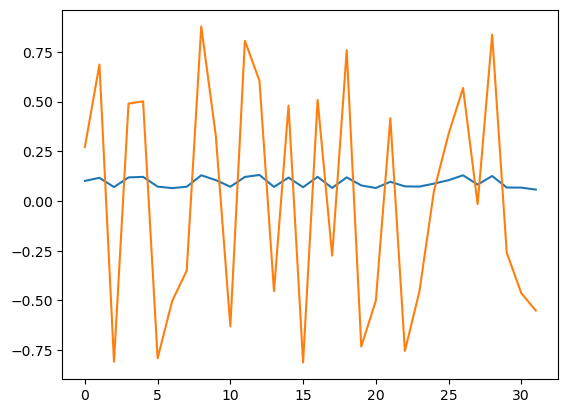

In [266]:
plt.plot(output.detach().numpy())
plt.plot(batch[1].detach().numpy())